# Tarefa 02: Classificação através de Redes Neurais e Fuzzy
Alunos:  
@ Elizianne Marinho Branches Farias  
@ Tiago Buatim Nion da Silveira  

Classificação de cédulas bancárias utilizando como entrada os parâmetros da transformada wavelet da imagem da cédula. Os dados utilizados são provenientes do *UCI Repository*. Deseja-se definir duas soluções diferentes para o problema de classificação, uma utilizando redes neurais e outra em sistemas fuzzy. Para tanto, as seguintes etapas de análise e classificação serão conduzidas:

**[I. Pré-processamento](#I)**  
[1.1. Importando os dados](#1.1)  
[1.2. Análise, verificação e limpeza dos dados](#1.2)  
[1.3. Correção de prevalência (balanceamento)](#1.3)  
[1.4. Particionando a base de dados](#1.4)  

**[II. Classificador baseado em redes neurais](#II)**  
[2.1 Multi-Layer Perceptron utilizando Scikit-Learning](#2.1)  
[2.2 Comparação do desempenho do classificador MLP com diferentes parâmetros](#2.2)

**[III. Classificador baseado em sistemas fuzzy](#III)**  

## I. Pré-processamento <a class="anchor" id="I"></a>

In [1]:
## Bibliotecas necessárias à execução do caderno:
import numpy as np  #Métodos matemáticos para computação científica
import pandas as pd  #Python Data Analysis Library
import matplotlib.pyplot as plt  #Visualização de dados
%matplotlib inline
import seaborn as sns  #Visualização renderizada

### 1.1 Importando os dados <a class="anchor" id="1.1"></a>
Os dados são importados de um arquivo texto, tabulados por vírgula, com os seguintes atributos de entrada (informações da transformada Wavelet da imagem):  
1.variance of Wavelet Transformed image (continuous)  
2.skewness of Wavelet Transformed image (continuous)  
3.curtosis of Wavelet Transformed image (continuous)  
4.entropy of image (continuous)  

A saída já está discriminada no conjunto de dados, sendo:
class (integer): 0 autêntica 1 falsificada

In [2]:
## Leitura do arquivo de entrada:
money = pd.read_csv('../fuzzy_rn_classif/dados_autent_bancaria.txt', sep=',',
                   names=['varCWT', 'skewCWT', 'curtCWT', 'entropy', 'class'])  #Cabeçalho incluído manualmente

In [3]:
## Exibição das primeiras linhas da base de dados:
money.head(3)

,varCWT,skewCWT,curtCWT,entropy,class
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


### 1.2 Análise, verificação e limpeza dos dados: <a class="anchor" id="1.2"></a>
Esta etapa tem por objetivo fornecer uma descrição geral do conjunto de dados a ser trabalhado, permitindo a observação de *outliers*, por exemplo, e facilitando a posterior aplicação de modelos. Conforme o enunciado da tarefa, deve-se também avaliar a consistência dos dados (i.e. mesmas entradas apresentando saídas distintas), uma vez que inconsistências podem levar à não convergência dos classificadores.

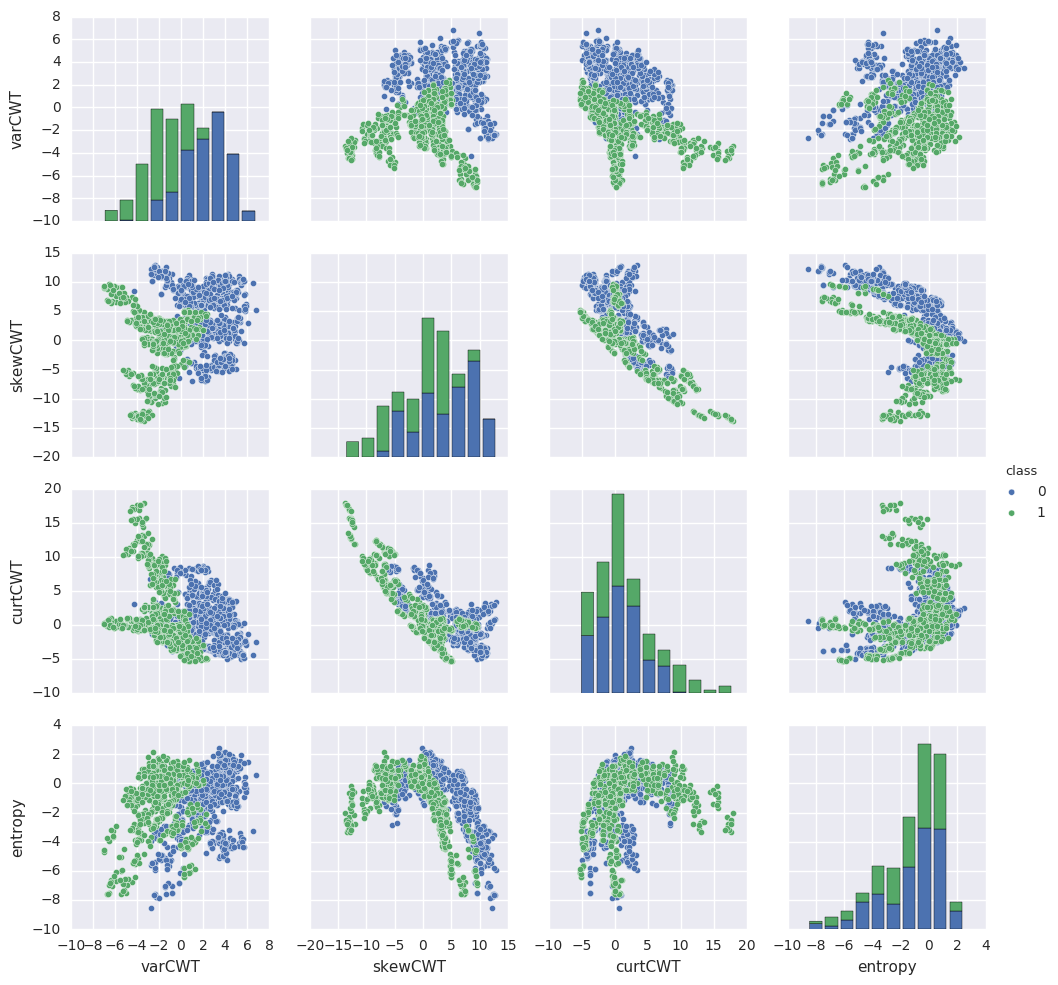

In [4]:
## Pairplot para visão geral do conjunto de dados:
sns.pairplot(money, hue="class", vars=['varCWT', 'skewCWT', 'curtCWT', 'entropy'])

In [5]:
## Verificando quantidade de registros e existência de elementos nulos:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
varCWT     1372 non-null float64
skewCWT    1372 non-null float64
curtCWT    1372 non-null float64
entropy    1372 non-null float64
class      1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


#### Consistência dos dados:

In [6]:
## Verificando a existência de registros duplicados:
duplicadas = money.duplicated(subset=['varCWT', 'skewCWT', 'curtCWT', 'entropy'], keep=False)
#O parâmetro "keep=False" é utilizado para que todos os registros repetidas sejam considerados, permitindo avaliar a classe
duplicadas.value_counts()

False    1337
True       35
dtype: int64

In [7]:
## Inspeção dos valores, se há divergência na atribuição de classes para entradas idênticas:
money[duplicadas]['class'].describe()

count    35.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: class, dtype: float64

In [8]:
## Não havendo divergência (no resultado acima há apenas a classe 0), serão removidas apenas um dos registros duplicados:
money.drop_duplicates(subset=['varCWT', 'skewCWT', 'curtCWT', 'entropy'], keep='first', inplace=True)

In [9]:
## Gera um novo índice após a remoção das linhas duplicadas:
money.reset_index(inplace=True)

In [10]:
## Verificação do conjunto após a remoção, agora sem nenhum registro duplicado:
money[money.duplicated(subset=['varCWT', 'skewCWT', 'curtCWT', 'entropy'], keep=False)]

,index,varCWT,skewCWT,curtCWT,entropy,class


### 1.3 Correção de prevalência (balanceamento) <a class="anchor" id="1.3"></a>

#### Quão balanceadas estão as classes?
Para o problema em questão há duas classes possíveis: (0) quando as notas são verdadeiras; e (1) quando as notas são falsas. É importante sabermos se no conjunto de dados trabalhado as classes estão distribuídas uniformemente. Para tanto, um histograma com a distribuição dos valores da classe pode ser construído ou, uma vez que só há dois valores possíveis, a própria contagem dos mesmos já é o suficiente. Caso não estejam balanceadas, há diferentes técnicas (fora do escopo deste trabalho) para realizar uma amostragem adequada.

In [11]:
## Contagem do número de instâncias por classe:
print('Instâncias classificadas como autênticas:', len(money.loc[money['class'] == 0]))
print('Instâncias classificadas como falsificadas:', len(money.loc[money['class'] == 1]))

Instâncias classificadas como autênticas: 738
Instâncias classificadas como falsificadas: 610


#### Como as instânciasde cada classe estão distribuídas no conjunto de dados?
Para esta questão, simplesmente *plotar* o atributo *class* da base de dados é suficiente para determinar se as classes já estão separadas ou se estão aleatórias. Conforme mostrado abaixo, as primeiras 738 instâncias pertencem à classe de notas autênticas, enquanto as próximas 610 à classe de notas falsificadas.

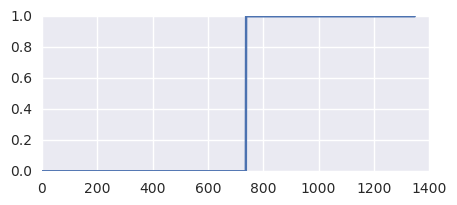

In [12]:
plt.figure(figsize=(5,2))
plt.plot(money['class'])

#### Decisão quanto ao balanceamento:
Dado o tamanho do conjunto e a variação de 17.3% no número de registros entre as classes (610/738), a atual distribuição de classes poderia ser considerada satisfatória. Entretanto, considerando as especificações da tarefa para a composição do conjunto de treino e teste, um novo *dataframe* será constituído com uma distribuição homogênea das classes (ver [Seção 1.4](#1.4)):

In [13]:
## Copiando o dataframe: 
pmoney = money.copy()
pmoney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 6 columns):
index      1348 non-null int64
varCWT     1348 non-null float64
skewCWT    1348 non-null float64
curtCWT    1348 non-null float64
entropy    1348 non-null float64
class      1348 non-null int64
dtypes: float64(4), int64(2)
memory usage: 63.3 KB


In [14]:
## Escolha aleatória de 128 (738-610) istâncias da classe 0 para serem removidas (balanceamento):
ixRow2drop = np.arange(len(pmoney.loc[pmoney['class']==0])) #Cria uma lista de 0 a len(class) - Índices previamente ordenados;
np.random.shuffle(ixRow2drop)  #Embaralha as posições dos índices;
ixRow2drop = ixRow2drop[:128]  #Seleciona as primeiras 128 amostras da lista de índice;

In [15]:
## Remove do dataframe pmoney as amostras selecionadas aleatoriamente na etapa anterior:
pmoney.drop(ixRow2drop, inplace=True)
pmoney.reset_index(inplace=True)  #Reordena o índice após a remoção das linhas
pmoney.info()
## Exibindo o número de instâncias por classe do conjunto *pmoney*, agora homogêneo:
print('\nInstâncias classificadas como autênticas:', len(pmoney.loc[pmoney['class'] == 0]))
print('Instâncias classificadas como falsificadas:', len(pmoney.loc[pmoney['class'] == 1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 7 columns):
level_0    1220 non-null int64
index      1220 non-null int64
varCWT     1220 non-null float64
skewCWT    1220 non-null float64
curtCWT    1220 non-null float64
entropy    1220 non-null float64
class      1220 non-null int64
dtypes: float64(4), int64(3)
memory usage: 66.8 KB

Instâncias classificadas como autênticas: 610
Instâncias classificadas como falsificadas: 610


### 1.4 Particionando a base de dados: <a class="anchor" id="1.4"></a>
De acordo com o enunciado da tarefa, é necessário "definir Conjunto de treinamento: 40% da classe 1 + 40% da classe 0. O conjunto de treinamento poderá ainda ser particionado em Tr mais validação (para o treinamento das RN). Definir Conjunto de teste: 10% da classe 1 + 10% da classe 0".  
Sendo assim, a partir do conjunto *pmoney* já balanceado com 1220 amostras, serão selecionadas aleatoriamente (através do método *np.random.shuffle*) as 976 amostras do conjunto de treino e 244 amostras do conjunto de teste. Ainda, para a aplicação de redes neurais, o conjunto de treino será particionado em *treino + validação* utilizando a técnica k-fold. 

In [16]:
## Seleção das amostras de treino e teste da classe 0:
ixClass0 = pmoney.loc[pmoney['class']==0].index.values  #Cria uma lista com os índices das instâncias pertencentes à classe 0;
np.random.shuffle(ixClass0)  #Embaralha as posições dos índices;
ixTreino0 = ixClass0[:488]  #Seleciona as primeiras 488 amostras da lista de índice para treino;
ixTeste0 = ixClass0[488:610]  #Seleciona as 122 amostras restantes para teste.

## Seleção das amostras de treino e teste da classe 1:
ixClass1 = pmoney.loc[pmoney['class']==1].index.values  #Cria uma lista com os índices das instâncias pertencentes à classe 1;
np.random.shuffle(ixClass1)  #Embaralha as posições dos índices;
ixTreino1 = ixClass1[:488]  #Seleciona as primeiras 488 amostras da lista de índice para treino;
ixTeste1 = ixClass1[488:610]  #Seleciona as 122 amostras restantes para teste.

## Índice conjunto de treino:
ixTreino = np.concatenate((ixTreino0, ixTreino1))
ixTeste = np.concatenate((ixTeste0, ixTeste1))

In [17]:
## Definição do conjunto de treino:
treino = pmoney.loc[ixTreino]
## Definição do conjunto de teste:
teste = pmoney.loc[ixTeste]

In [18]:
## Verificação dos conjuntos particionados: 
print('Quantidade de instâncias no conjunto "Treino":', len(treino))
print('\tClasse0:', len(treino.loc[treino['class'] == 0]))
print('\tClasse1:', len(treino.loc[treino['class'] == 1]))
print('\nQuantidade de instâncias no conjunto "Teste":', len(teste))
print('\tClasse0', len(teste.loc[teste['class'] == 0]))
print('\tClasse1', len(teste.loc[teste['class'] == 1]))

Quantidade de instâncias no conjunto "Treino": 976
	Classe0: 488
	Classe1: 488

Quantidade de instâncias no conjunto "Teste": 244
	Classe0 122
	Classe1 122


## II. Classificador baseado em redes neurais <a class="anchor" id="II"></a>
Nesta tarefa, a rede neural utilizada como classificador é a *MLP - MultiLayer Perceptron*, treinada pelo algoritmo de *backpropagation*. Para a tarefa é requerido testar diferentes estruturas de redes neurais (camadas ocultas e números de neurônios em cada camada oculta, função de ativação, parâmetros do algoritmo de treinamento, dados de validação, uso do bias, entre outros).

Classificador MLP: http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [19]:
from sklearn.neural_network import MLPClassifier  #Redes neurais: classificador MLP
from sklearn.cross_validation import KFold  #Validação cruzada utilizando k-fold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import sklearn
sklearn.__version__

/home/anaconda3/envs/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'0.18.1'

### 2.1 Multi-Layer Perceptron utilizando Scikit-Learning <a class="anchor" id="2.1"></a>

Baseado nos comentários de Robi Polikar, optou-se por utilizar *k-fold cross validation*, com k=10. Esta técnica consiste em dividir o conjunto de treino em *k* partes, realizando *k* iterações de treino do classificador. Em cada iteração, a k-ésima subparte é considerada o conjunto de validação, enquanto as 'k-1' partes restantes são consideradas como o conjunto de treino.

In [20]:
kf = KFold(treino.shape[0], n_folds=10, random_state=1)

In [21]:
## Atributos considerados no treinamento:
features = ['varCWT', 'skewCWT', 'curtCWT', 'entropy']

#### Definindo os parâmetros da rede MLP:
Referência completa: http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

- ***hidden_layer_sizes***: é uma tupla onde cada elemento representa o número de neurônios na respectiva camada. E.g. hidden_layer_sizes=(10,10) representa uma rede MLP com duas camadas ocultas contendo 10 neurônios cada qual.
- ***activation***: escolha da função de ativação para as camadas ocultas, admitindo as opções *identity, logistic, tanh* e *relu* (consultar a referência para o detalhe de cada função). Para este trabalho foi escolhida a função *logistic*, uma vez que possui a mesma saída da função sigmoidal.
- ***solver***: esta implementação permite diferentes 'solucionadores'. A opção escolhida corresponde ao *stochastic gradient descent*, similar ao algoritmo estudado em aula.
- ***learning_rate*** e ***learning_rate_init***: corresponde ao modo de variação/adaptação da taxa de aprendizado, bem como à definição do seu valor inicial.
- ***momentum***: recurso utilizado para se evitar os mínimos locais no treinamento da rede. Conforme sugerido em aula, o valor escolhido é de 0.9. Há o recurso de se aplicar o "Nesterov's momentum", resultando em maior otimização (Ver https://stats.stackexchange.com/questions/179915/whats-the-difference-between-momentum-based-gradient-descent-and-nesterovs-ac)
- ***max_iter***: número máximo de iterações. Esta implementação, no entanto, interrompe a iteração quando não houver alteração na função de perda ao decorrer de duas épocas. O valor é definido através do parâmetro ***tol***. 

Além destes, há outros parâmetros que podem ser definidos, conforme visto abaixo na saída do comando *neural_clf.get_params*. Nesta implementação, no entanto, não foi encontrada a possibilidade de se definir os valores iniciais de bias e dos pesos. Ao final do treinamento, porém, os mesmos podem ser verificados através dos atributos *intercepts_* e *coefs_*, respectivamente.


In [22]:
## O classificador MLP é definido com os seguintes parâmetros:
neural_clf = MLPClassifier(hidden_layer_sizes=(10,10), 
                           activation='logistic', 
                           solver='sgd',
                           learning_rate='constant', 
                           learning_rate_init=0.01,
                           momentum=0.9, 
                           max_iter=1000, 
                           verbose=True)

In [23]:
## Verificação de todos os parâmetros (passados ou por padrão) do classificador neural MLP:
neural_clf.get_params

<bound method BaseEstimator.get_params of MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.01, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)>

#### Treinamento da rede MLP:

In [24]:
predictions = []
for train, test in kf:
    train_predictors = (treino[features].iloc[train,:])  # The predictors we're using the train the algorithm.
    train_target = treino['class'].iloc[train]            # The target we're using to train the algorithm.
    # Training the algorithm using the predictors and target.
    neural_clf.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = neural_clf.predict(treino[features].iloc[test,:])
    predictions.append(test_predictions)

Iteration 1, loss = 0.66637927
Iteration 2, loss = 0.66562596
Iteration 3, loss = 0.66449288
Iteration 4, loss = 0.66319506
Iteration 5, loss = 0.66171444
Iteration 6, loss = 0.66022022
Iteration 7, loss = 0.65842750
Iteration 8, loss = 0.65658131
Iteration 9, loss = 0.65455789
Iteration 10, loss = 0.65251570
Iteration 11, loss = 0.65035113
Iteration 12, loss = 0.64817754
Iteration 13, loss = 0.64545561
Iteration 14, loss = 0.64276011
Iteration 15, loss = 0.63988032
Iteration 16, loss = 0.63705311
Iteration 17, loss = 0.63394403
Iteration 18, loss = 0.63063570
Iteration 19, loss = 0.62706946
Iteration 20, loss = 0.62333922
Iteration 21, loss = 0.61947640
Iteration 22, loss = 0.61523279
Iteration 23, loss = 0.61072621
Iteration 24, loss = 0.60603423
Iteration 25, loss = 0.60116049
Iteration 26, loss = 0.59593817
Iteration 27, loss = 0.59047177
Iteration 28, loss = 0.58464850
Iteration 29, loss = 0.57865447
Iteration 30, loss = 0.57221870
Iteration 31, loss = 0.56546703
Iteration 32, los

In [25]:
predictions = np.concatenate(predictions, axis=0)

#### Métricas de desempenho:

In [26]:
## Medida da acurácia no treino:
accuracy = np.where(predictions==treino['class'], 1, 0).sum() / float(len(treino))
print(accuracy)

0.992827868852


In [27]:
## Matriz confusão para o conjunto de treino:
print(metrics.confusion_matrix(treino['class'], predictions))

[[484   4]
 [  3 485]]


In [28]:
## Matriz confusão para o conjunto de teste:
teste_predictions = neural_clf.predict(teste[features])
print(metrics.confusion_matrix(teste['class'],teste_predictions))

[[122   0]
 [  0 122]]


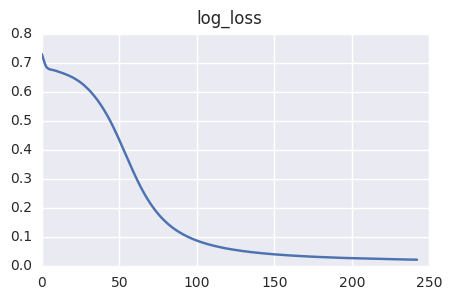

In [29]:
## Gráfico da função perda para o classificador já treinado:
plt.figure(figsize=(5,3))
plt.suptitle(neural_clf.loss)
plt.plot(neural_clf.loss_curve_)
#plt.plot(neural_clf.loss_curve_)

### 2.2 Comparação do desempenho do classificador MLP com diferentes parâmetros <a class="anchor" id="2.2"></a>
Nesta etapa, deseja-se comparar o desempenho do classificador baseado em rede neural utilizando-se diferentes parâmetros do MLP, implementado via Scikit-Learning. Os classificadores são definidos em um único bloco e a análise do melhor parâmetro é dada através da interpretação do gráfico da função perda.

Referências:  
1.https://plot.ly/scikit-learn/plot-mlp-training-curves/  
2.http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html

In [30]:
## Inicializando os parâmetros:
params=[]
labels=[]
plot_args=[]

#### A. Em relação à atualização da taxa de aprendizado e emprego de *momento*:

In [31]:
## Definição dos meios de atualização da taxa de aprendizado: 
params.append([{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.01, 'activation': 'logistic'},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.01, 'activation': 'logistic'},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.01, 'activation': 'logistic'},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.01, 'activation': 'logistic'},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.01, 'activation': 'logistic'},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.01, 'activation': 'logistic'}])

labels.append(["constant", "constant & momentum",
             "constant & Nesterov's",
             "inv-scaling", "inv-scaling & momentum",
             "inv-scaling & Nesterov's"])

plot_args.append([{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'}])

#### B. Em relação à taxa de aprendizado inicial:

In [32]:
## Definição dos meios de atualização da taxa de aprendizado: 
params.append([{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.001, 'activation': 'logistic'},
             {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.01, 'activation': 'logistic'},
             {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.1, 'activation': 'logistic'},
             {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.5, 'activation': 'logistic'},
             {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 1, 'activation': 'logistic'},])

labels.append(["eta = 0.001", "eta = 0.01",
            "eta = 0.1", "eta = 0.5", 
            "eta = 1"])

plot_args.append([{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'black', 'linestyle': '--'},
             {'c': 'purple', 'linestyle': '--'}])

#### C. Em relação às camadas ocultas e o número de neurônios:

In [33]:
## Definição dos meios de atualização da taxa de aprendizado: 
params.append([{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': False, 
           'learning_rate_init': 0.01, 'hidden_layer_sizes':(4,4), 'activation': 'logistic'},
             {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': False, 
           'learning_rate_init': 0.01, 'hidden_layer_sizes':(4,10), 'activation': 'logistic'},
             {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': False, 
           'learning_rate_init': 0.01, 'hidden_layer_sizes':(10,10), 'activation': 'logistic'},
             {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': False, 
           'learning_rate_init': 0.01, 'hidden_layer_sizes':(40,10), 'activation': 'logistic'},
            {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9, 'nesterovs_momentum': False, 
           'learning_rate_init': 0.01, 'hidden_layer_sizes':(40,40), 'activation': 'logistic'}])

labels.append(["hidden=(4,4)", "hidden=(4,10)",
            "hidden=(10,10)", "hidden=(40,10)",
            "hidden=(40,40)"])

plot_args.append([{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'}])

#### D. Em relação às funções de ativação:

In [34]:
## Definição dos meios de atualização da taxa de aprendizado: 
params.append([{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.01, 'activation': 'identity'},
            {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.01, 'activation': 'logistic'},
            {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.01, 'activation': 'tanh'},
            {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.01, 'activation': 'relu'}])

labels.append(["identity", "logistic", "tanh", "relu"])

plot_args.append([{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'black', 'linestyle': '-'}])

In [35]:
## Subtítulos dos gráficos da análise abaixo:
nomes = ['Learning rate type and Momentum',
         'Initial learning rate',
         'hidden_layer_sizes', 
         'activation_function']

In [36]:
def plot_on_dataset(treino, ax, name, ix):
    #print("\nlearning on dataset %s" % name)
    ax.set_title(name)
    mlps = []
    max_iter = 400

    for label, param in zip(labels[ix], params[ix]):
        train_predictors = (treino[features].iloc[train,:])  # The predictors we're using the train the algorithm.
        train_target = treino['class'].iloc[train]            # The target we're using to train the algorithm.
        
        #print("training: %s" % label)
        mlp = MLPClassifier(verbose=0, random_state=0,
                            max_iter=max_iter, **param)
        mlp.fit(train_predictors, train_target)
        mlps.append(mlp)
        #print("Training set score: %f" % mlp.score(train_predictors, train_target))
        #print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels[ix], plot_args[ix]):
            ax.plot(mlp.loss_curve_, label=label, **args)
            ax.set_xlabel='epoch'
            ax.set_ylabel='loss'
            ax.legend(loc="best")

#### Análise do resultado:

/home/anaconda3/envs/python3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


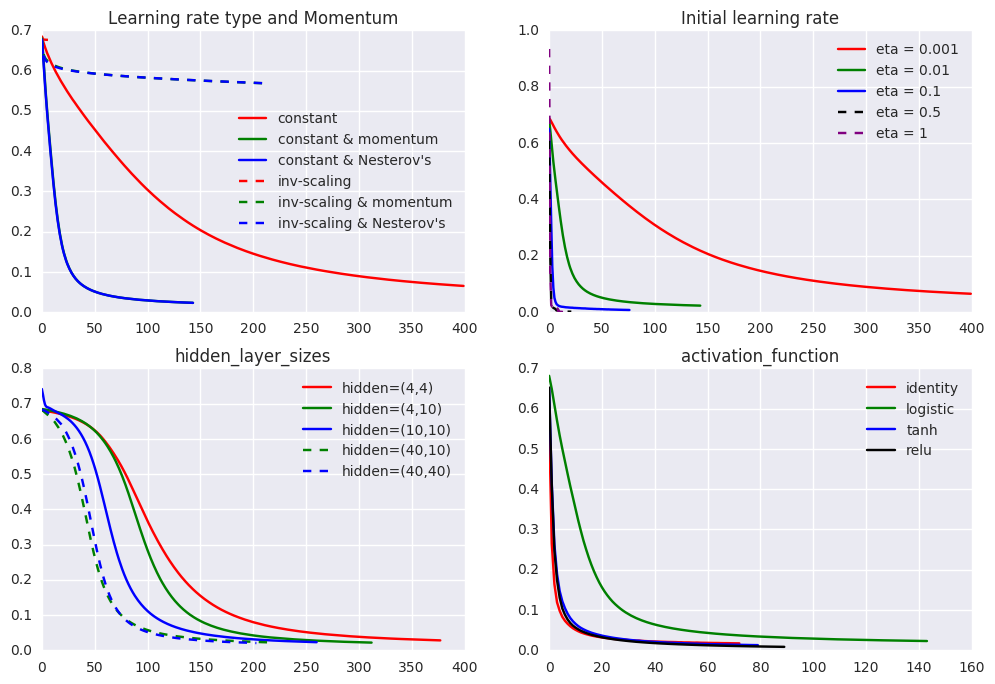

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, name, ix in zip(axes.ravel(), nomes, np.arange(0,4)):
    plot_on_dataset(treino, ax=ax, name=name, ix=ix)

## III. Classificador baseado em sistemas fuzzy <a class="anchor" id="III"></a>
Referências: 
- http://pythonhosted.org/scikit-fuzzy/install.html
- http://pythonhosted.org/scikit-fuzzy/_downloads/plot_tipping_problem_newapi.py

#### Nota de aula (20.04.2017):
Para criar o particionamento dos conjuntos fuzzy pode ser utilizado o agrupamento dos dados. A  Profa. Myriam dá o exemplo com a dispersão de duas classes (R2) e da projeção dos pontos em cada eixo considerado. [Um colega utilizou a análise de percentil...]

A Profa. Myriam fala sobre o conhecimento de domínio para a determinação da semântica dos conjuntos. Por exemplo, na aplicação vou saber denominar as partições do conjunto em "baixa, média e alta", por exemplo.
--> Importante: no particionamento é muito importante não deixar gaps entre as semânticas. Pois senão a regra ficará sempre com 0 

In [66]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

#### Definição do problema: 
We would formulate this problem as:

* Antecednets (Inputs)
   - `service`
      * Universe (ie, crisp value range): How good was the service of the wait
        staff, on a scale of 0 to 10?
      * Fuzzy set (ie, fuzzy value range): poor, acceptable, amazing
   - `food quality`
      * Universe: How tasty was the food, on a scale of 0 to 10?
      * Fuzzy set: bad, decent, great
* Consequents (Outputs)
   - `tip`
      * Universe: How much should we tip, on a scale of 0% to 25%
      * Fuzzy set: low, medium, high
* Rules
   - IF the *service* was good  *or* the *food quality* was good,
     THEN the tip will be high.
   - IF the *service* was average, THEN the tip will be medium.
   - IF the *service* was poor *and* the *food quality* was poor
     THEN the tip will be low.
* Usage
   - If I tell this controller that I rated:
      * the service as 9.8, and
      * the quality as 6.5,
   - it would recommend I leave:
      * a 20.2% tip.

In [46]:
sns.pairplot?

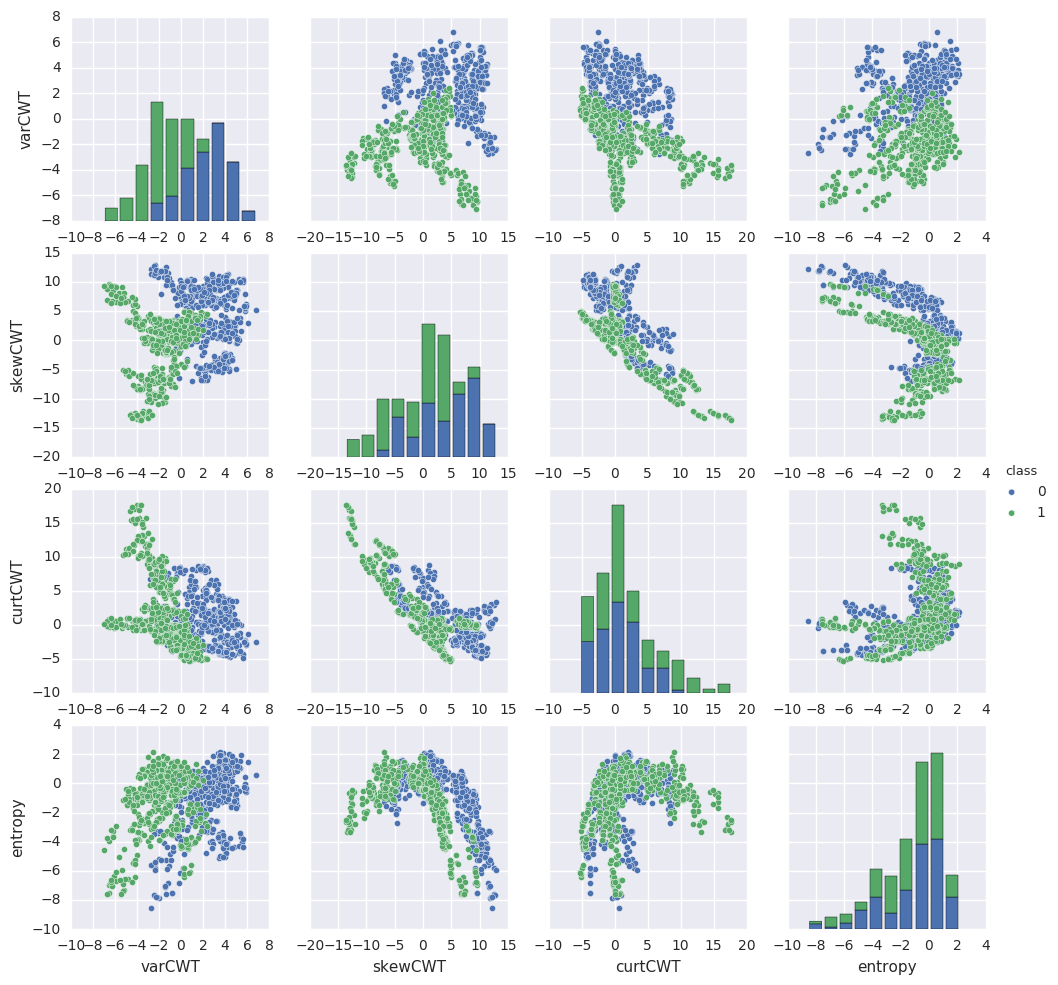

In [52]:
## Gerando novamente o pairplot para visão geral do conjunto de TREINO, mantendo o eixo em cada subgráfico:
g = sns.pairplot(treino, hue="class", vars=['varCWT', 'skewCWT', 'curtCWT', 'entropy'])
for ax in g.axes.flat:
    _ = plt.setp(ax.get_xticklabels(), visible=True)

In [53]:
treino.describe()

,level_0,index,varCWT,skewCWT,curtCWT,entropy,class
count,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000
mean,704.713115,722.271516,0.235903,1.530096,1.555336,-1.167882,0.500000
std,394.240124,401.962497,2.889026,5.969058,4.502094,2.109773,0.500256
min,3.000000,3.000000,-7.036400,-13.677900,-5.261300,-8.548200,0.000000
25%,365.750000,378.750000,-1.939400,-2.227100,-1.633225,-2.382450,0.000000
50%,737.000000,761.000000,0.179130,1.963750,0.616630,-0.586000,0.500000
75%,1052.250000,1076.250000,2.669125,6.412150,3.663950,0.418413,1.000000
max,1347.000000,1371.000000,6.824800,12.951600,17.677200,2.154700,1.000000


In [82]:
varCWT.automf?

In [83]:
varCWT = ctrl.Antecedent(treino['varCWT'], 'varCWT')
skewCWT = ctrl.Antecedent(treino['skewCWT'], 'skewCWT')
curtCWT = ctrl.Antecedent(treino['curtCWT'], 'curtCWT')
classiFuzzy = ctrl.Consequent([0,1], 'class')

In [84]:
varCWT.automf(number=3, variable_type='quality', names=['desfav', 'indif', 'fav'])
skewCWT.automf(number=3, variable_type='quality', names=['desfav', 'indif', 'fav'])
curtCWT.automf(number=3, variable_type='quality', names=['desfav', 'indif', 'fav'])

In [85]:
# Custom membership functions can be built interactively with a familiar,
# Pythonic API
#classiFuzzy['autentico'] = fuzz.trimf(classiFuzzy.universe, [1, 1, 1])
#classiFuzzy['falso'] = fuzz.trimf(tip.universe, [0, 13, 25])
classiFuzzy['autentico'] = [0,1]
classiFuzzy['falso'] = [1,0]

/home/anaconda3/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


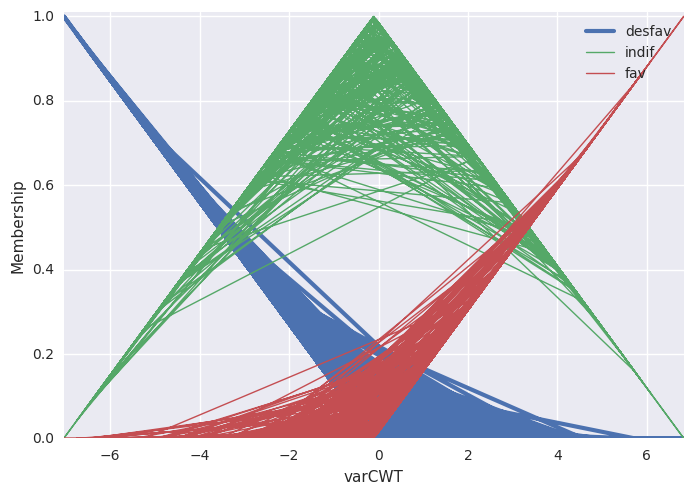

In [79]:
## Visualização das variáveis fuzzy:
varCWT['desfav'].view()

/home/anaconda3/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


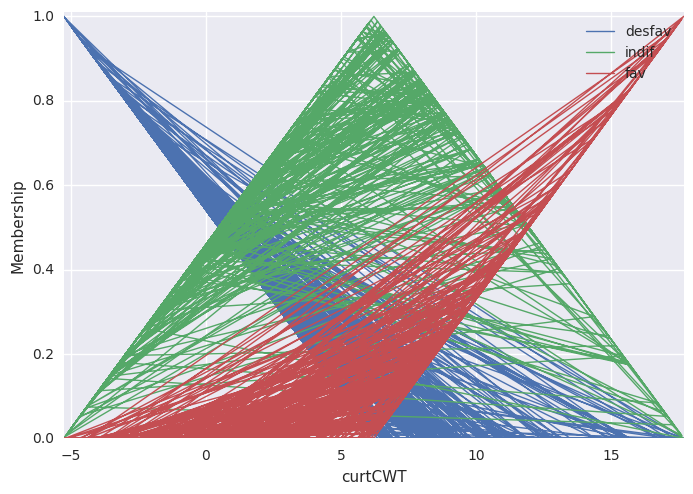

In [81]:
curtCWT.view()

In [ ]:
tip.view()

In [ ]:
"""Fuzzy rules
-----------

Now, to make these triangles useful, we define the *fuzzy relationship*
between input and output variables. For the purposes of our example, consider
three simple rules:

1. If the food is poor OR the service is poor, then the tip will be low
2. If the service is average, then the tip will be medium
3. If the food is good OR the service is good, then the tip will be high.

Most people would agree on these rules, but the rules are fuzzy. Mapping the
imprecise rules into a defined, actionable tip is a challenge. This is the
kind of task at which fuzzy logic excels.
"""

rule1 = ctrl.Rule(quality['poor'] | service['poor'], tip['low'])
rule2 = ctrl.Rule(service['average'], tip['medium'])
rule3 = ctrl.Rule(service['good'] | quality['good'], tip['high'])

In [ ]:
"""Control System Creation and Simulation
---------------------------------------

Now that we have our rules defined, we can simply create a control system
via:
"""

tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])

In [ ]:
"""
In order to simulate this control system, we will create a
``ControlSystemSimulation``.  Think of this object representing our controller
applied to a specific set of cirucmstances.  For tipping, this might be tipping
Sharon at the local brew-pub.  We would create another
``ControlSystemSimulation`` when we're trying to apply our ``tipping_ctrl``
for Travis at the cafe because the inputs would be different.
"""

tipping = ctrl.ControlSystemSimulation(tipping_ctrl)

In [ ]:
"""
We can now simulate our control system by simply specifying the inputs
and calling the ``compute`` method.  Suppose we rated the quality 6.5 out of 10
and the service 9.8 of 10.
"""
# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
tipping.input['quality'] = 0.9
tipping.input['service'] = 7.8

In [ ]:
# Crunch the numbers
tipping.compute()

In [ ]:
"""
Once computed, we can view the result as well as visualize it.
"""
print(tipping.output['tip'])
tip.view(sim=tipping)

In [ ]:
"""
.. image:: PLOT2RST.current_figure

The resulting suggested tip is **20.24%**.

Final thoughts
--------------

The power of fuzzy systems is allowing complicated, intuitive behavior based
on a sparse system of rules with minimal overhead. Note our membership
function universes were coarse, only defined at the integers, but
``fuzz.interp_membership`` allowed the effective resolution to increase on
demand. This system can respond to arbitrarily small changes in inputs,
and the processing burden is minimal.

"""